In [148]:
import os
import random
import matplotlib.pyplot as plt
import statistics
import numpy
import yaml

# https://retirementplans.vanguard.com/VGApp/pe/pubeducation/calculators/RetirementNestEggCalc.jsf


In [149]:
!python -m pip install PyYAML


In [150]:
def load_personal_finance(path):
    personal_finance = {}
    if os.path.exists(path):
        with open(path) as f:
            personal_finance = yaml.safe_load(f)
        # print(personal_finance)
    return personal_finance


In [152]:
#@title age { run: "auto" }
current_age = 25 #@param {type:"slider", min:0, max:100, step:1}
retire_age = 45 #@param {type:"slider", min:0, max:100, step:1}
end_of_life_age = 90 #@param {type:"slider", min:0, max:100, step:1}


In [ ]:
#@title savings { run: "auto" }
post_tax_current_savings = 100000 #@param {type:"slider", min:0, max:10000000, step:1000}
yearly_post_tax_and_benefits_income = 100000 #@param {type:"slider", min:0, max:10000000, step:1000}
yearly_post_tax_and_benefits_spend = 50000 #@param {type:"slider", min:0, max:10000000, step:1000}

tax_deferred_current_savings=20000 #@param {type:"slider", min:0, max:10000000, step:1000}
tax_deferred_yearly_savings=19000 #@param {type:"slider", min:0, max:10000000, step:1000}
tax_deferred_employer_matching_rate = 1 #@param {type:"slider", min:0, max:2, step:0.1}
tax_deferred_maximum_of_federal_limit = 0.035 #@param {type:"slider", min:0, max:2, step:0.001}
tax_deferred_federal_limit = 280000 #@param {type:"slider", min:0, max:10000000, step:10000}

tax_free_current_savings =5000 #@param {type:"slider", min:0, max:10000, step:1000}
tax_free_yearly_savings	 =26000 #@param {type:"slider", min:0, max:100000, step:1000}


In [ ]:
#@title rates { run: "auto" }
tax_rate = 0.30 #@param {type:"slider", min:0, max:1, step:0.01}
post_tax_to_tax_deferred_adj = 1/(1 - tax_rate)

inflation_min = 1 #@param {type:"slider", min:-5, max:25, step:1}
inflation_max = 4 #@param {type:"slider", min:-5, max:25, step:1}
inflation = lambda : random.uniform(inflation_min,inflation_max)/100

rate_of_return_min = -8 #@param {type:"slider", min:-10, max:100, step:1}
rate_of_return_max = 12 #@param {type:"slider", min:-10, max:100, step:1}
rate_of_return = lambda : random.uniform(rate_of_return_min,rate_of_return_max)/100

simulations = 100

# # update with values from personal_finance
# personal_finance = load_personal_finance(os.path.expanduser("~/personal_finance.yaml"))
# for k,v in personal_finance.items():
#     globals()[k] = v
# print(personal_finance)


In [153]:
def subtract_with_remainder(balance, amount):
    """
    subtract from balance, cap minimum balance at zero and return remaining amount (to subtract)
    :param balance: 
    :param amount: 
    :return: 
    """
    if balance > 0:
        balance -= amount
        if balance > 0:
            amount = 0
        else:
            amount = abs(balance)
            balance= 0
    return balance, amount

def subtract_balances(amount: int, 
             post_tax_to_tax_deferred_adj: float, 
             step: int, 
             post_tax_balance: numpy.ndarray, 
             tax_deferred_balance: numpy.ndarray, 
             tax_free_balance: numpy.ndarray):
    
    post_tax_balance[step], amount = subtract_with_remainder(post_tax_balance[step],amount)
    
    amount *= post_tax_to_tax_deferred_adj
    tax_deferred_balance[step], amount = subtract_with_remainder(tax_deferred_balance[step], amount)
    amount /= post_tax_to_tax_deferred_adj

    tax_free_balance[step], amount = subtract_with_remainder(tax_free_balance[step], amount)


In [154]:
steps = end_of_life_age - current_age
sims = numpy.zeros((simulations,steps))

for sim in range(simulations):
    post_tax_balance = numpy.zeros(steps)
    post_tax_balance[0] = post_tax_current_savings
    
    tax_deferred_balance = numpy.zeros(steps)
    tax_deferred_balance[0] = tax_deferred_current_savings
    
    tax_free_balance = numpy.zeros(steps)
    tax_free_balance[0] = tax_free_current_savings
    
    yearly_post_tax_and_benefits_spend_inflation_adjusted = numpy.zeros(steps)
    yearly_post_tax_and_benefits_spend_inflation_adjusted[0] = yearly_post_tax_and_benefits_spend
    
    for step in range(1, steps):
        retired = (step + current_age) >= retire_age 
        this_year_rate_of_return = rate_of_return()
        this_year_inflation = inflation()
        yearly_post_tax_and_benefits_spend_inflation_adjusted[step] = \
            yearly_post_tax_and_benefits_spend_inflation_adjusted[step - 1] * (1 + this_year_inflation)
        
        post_tax_interest = post_tax_balance[step - 1] * this_year_rate_of_return
        tax_on_post_tax_interest = post_tax_interest * tax_rate
        post_tax_yearly_change = post_tax_interest + \
                        - tax_on_post_tax_interest + \
                        (yearly_post_tax_and_benefits_income if not retired else 0)
        
        tax_deferred_yearly_employer_contributions = min(
            tax_deferred_yearly_savings * tax_deferred_employer_matching_rate, 
            tax_deferred_maximum_of_federal_limit * tax_deferred_federal_limit)
        
        tax_deferred_yearly_change = tax_deferred_balance[step - 1] * this_year_rate_of_return + \
                                     (tax_deferred_yearly_savings if not retired else 0) + \
                                     (tax_deferred_yearly_employer_contributions if not retired else 0)
        
        tax_free_yearly_change = tax_free_balance[step - 1] * this_year_rate_of_return
        
        post_tax_balance[step] = post_tax_balance[step - 1] + post_tax_yearly_change
        tax_deferred_balance[step] = tax_deferred_balance[step - 1] + tax_deferred_yearly_change
        tax_free_balance[step] = tax_free_balance[step - 1] +  tax_deferred_yearly_change
                
        subtract_balances(yearly_post_tax_and_benefits_spend_inflation_adjusted[step], 
                 post_tax_to_tax_deferred_adj, 
                 step, 
                 post_tax_balance, 
                 tax_deferred_balance, 
                 tax_free_balance)
    
    sims[sim] = post_tax_balance + tax_deferred_balance + tax_free_balance

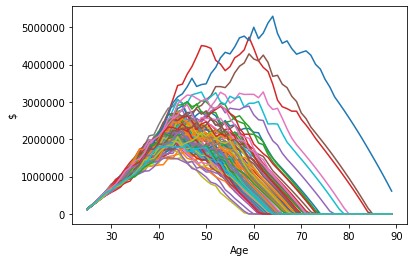

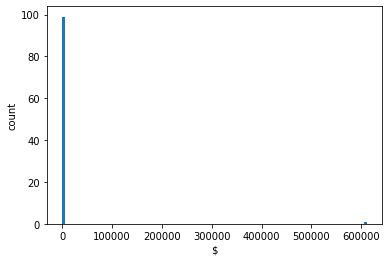

6111.025215896541


In [155]:
for sim in range(simulations):
    plt.plot(range(current_age, end_of_life_age), sims[sim])

plt.ylabel('$')
plt.xlabel('Age')
plt.show()

outcomes = sims[:, -1]
h = plt.hist(outcomes, bins=100)
plt.ylabel('count')
plt.xlabel('$')
plt.show()
print(statistics.mean(outcomes))